# First model
The goal of this model is to establish the pattern of importing image data and building a simple model.

Model performance is not a priority, that comes later.

In [61]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import misc
import matplotlib.pyplot as plt
from skimage.transform import resize

## Get data

In [62]:
IMAGE_PATH = 'data/images/capture/'

In [63]:
data = pd.DataFrame.from_csv('data/labels/rugby_image_labels_2.csv')

In [64]:
data.head()

,y
file_name,
1491257473.62.jpg,327.0
1491257474.29.jpg,336.0
1491257474.83.jpg,367.0
1491257475.45.jpg,392.0
1491257476.09.jpg,401.0


In [65]:
test_img = misc.imread(IMAGE_PATH + data.iloc[0].name,flatten=True)

In [66]:
test_img.shape

(480, 640)

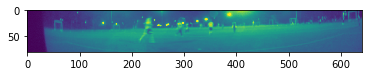

In [67]:
plt.imshow(test_img[240:320])
plt.show()

## Define image preprocessing (resizing)

In [68]:
def my_image_resize(img):
    return resize(image=(img[240:320]/(255/2))-1, output_shape=(20,80))

def my_image_resize_2(img):
    return img[240:320]/255

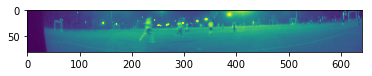

In [69]:
plt.imshow(my_image_resize_2(test_img))
plt.show()

In [70]:
my_image_resize_2(test_img).shape

(80, 640)

In [71]:
get_rows = 1000
# get sizes of image data 
m = data.shape[0]
image_size = [80,640]#test_img.shape
# total size of numpy volume
data_size = [get_rows, *image_size]

## Fetch images an calculate delta images

In [72]:
# fill numpy volume with image data
data_np = np.zeros(data_size)
count = 0
prev_img = None
for i, v in data[:get_rows].iterrows():

    if np.isnan(v['y']) == False:
        
        if not(count % 100):
            print(count)

        new_img = my_image_resize_2(misc.imread(IMAGE_PATH + i, flatten=True))
        if prev_img is not None:
            delta_img = np.clip((prev_img - new_img),a_min=0, a_max=1)
            data_np[count,:,:] =  delta_img
        prev_img = new_img
        count += 1

0
100
200
300
400
500
600
700
800
900


In [73]:
data_np[9]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00835685,  0.        ],
       [ 0.00279216,  0.00392157,  0.        , ...,  0.        ,
         0.        ,  0.00901568],
       [ 0.        ,  0.00392157,  0.        , ...,  0.00760785,
         0.00117254,  0.        ],
       ..., 
       [ 0.        ,  0.00089412,  0.00089412, ...,  0.        ,
         0.00856864,  0.        ],
       [ 0.00061569,  0.00364314,  0.00392157, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00505099,  0.        , ...,  0.00166273,
         0.        ,  0.        ]])

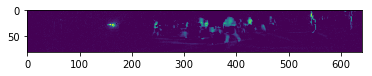

In [74]:
plt.imshow(data_np[20])
plt.show()

In [75]:
data_np.shape

(1000, 80, 640)

In [76]:
# np.save('data/numpy_images/d1.npy', data_np)

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X = data_np.reshape([*data_np.shape,1])
y = data.dropna()[:get_rows]/640

# skip first image as it had no previous image an therefore delta was not calculated
X = X[1:]
y = y[1:]

In [79]:
def print_image_labels(images, labels):
    for i,(p,) in enumerate(labels):
        print(p,i )
        temp_img = np.copy(images[i].reshape(images[3].shape[:-1]))
        pred_col = int(temp_img.shape[1]*p)
        temp_img[:, pred_col:pred_col+5] = 1
        print(pred_col)
        plt.imshow(temp_img)
        plt.show()

In [115]:
def print_image_labels_comp(images, labels, preds=None):
    for i,(p,) in enumerate(labels):
        print(p,i )
        temp_img = np.copy(images[i].reshape(images[0].shape[:-1]))
        lab = int(temp_img.shape[1]*p)
        pred = int(temp_img.shape[1]*preds[i])
        temp_img[:, lab:lab+5] = 1
        temp_img[:, pred:pred+5] = 0.5
        print(lab, pred)
        plt.imshow(temp_img)
        plt.show()

0.525 0
336


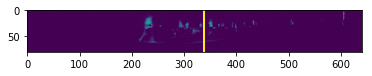

0.5734375 1
367


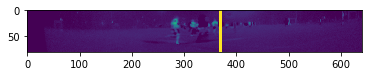

0.6125 2
392


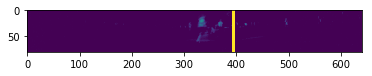

0.6265625 3
401


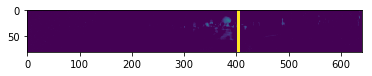

0.646875 4
414


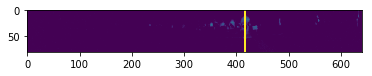

0.63125 5
404


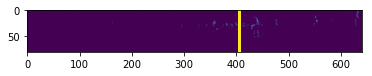

0.621875 6
398


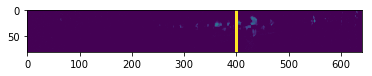

0.6640625 7
425


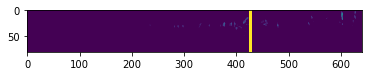

0.6609375 8
423


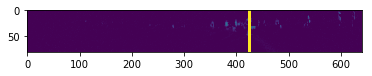

0.6171875 9
395


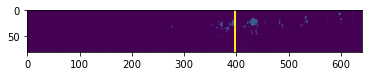

In [81]:
print_image_labels(X[:10], y[:10].values)

## Define and train network

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, RepeatVector, ConvLSTM2D
Recurrent, RNN, LSTM, SimpleRNN, TimeDistributed
from keras import optimizers

In [254]:
model = Sequential()

# model.add(Conv2D(16, kernel_size=(3, 3),batch_input_shape=(None, 80, 640, 1),
#                  activation='relu',
# #                  input_shape=(80, 640, 1),
#                  name='input'))

model.add(ConvLSTM2D(16, kernel_size=(3, 3), batch_input_shape=(1 ,None, 80, 640, 1),
                 activation='relu',
#                  input_shape=(None, 80, 640, 1), 
                     name='input', stateful=True))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, name='output'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [239]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print(x_train.shape, x_test.shape)

(799, 80, 640, 1) (200, 80, 640, 1)


In [240]:
x_train, x_test, y_train, y_test = X[:700], X[700:], y[:700], y[700:]

In [241]:
X[:300].shape

(300, 80, 640, 1)

In [242]:
y_tr.shape

(300, 1)

In [243]:
x_tr = X[:300].reshape(300,1,80,640,1)
x_ts = X[300:600].reshape(300,1,80,640,1)

y_tr = y[0:300]
y_ts = y[300:600]

In [244]:
model.fit(x_tr, y_tr, shuffle=False,
          batch_size=1,
          epochs=2,
          verbose=1,
          validation_data=(x_ts, y_ts))

Train on 300 samples, validate on 300 samples
Epoch 1/2
300/300 [==============================] - 116s 386ms/step - loss: 0.0314 - val_loss: 0.0751
Epoch 2/2
300/300 [==============================] - 110s 366ms/step - loss: 0.0030 - val_loss: 0.1803


## Show predictions

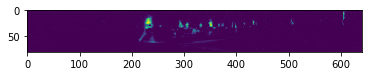

[[ 0.41053307]]


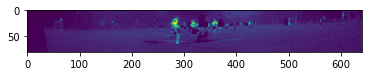

[[ 0.42348206]]


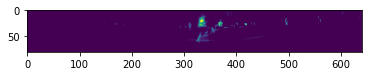

[[ 0.56543756]]


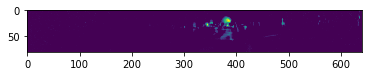

[[ 0.65431213]]


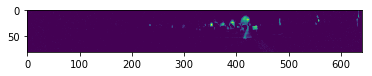

[[ 0.71380466]]


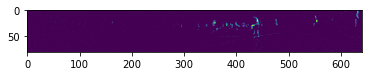

[[ 0.75452274]]


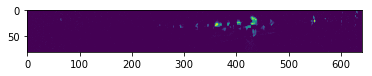

[[ 0.78978264]]


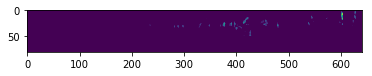

[[ 0.81298649]]


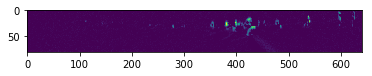

[[ 0.81421453]]


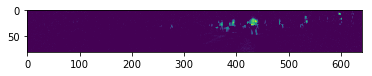

[[ 0.82149661]]


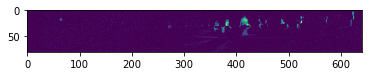

[[ 0.81746918]]


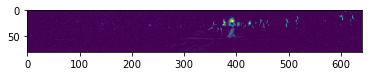

[[ 0.81276482]]


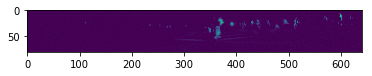

[[ 0.81532556]]


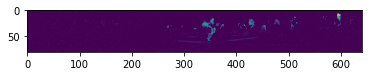

[[ 0.81632376]]


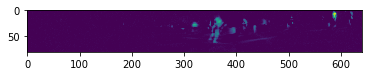

[[ 0.8172164]]


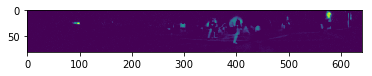

[[ 0.82743609]]


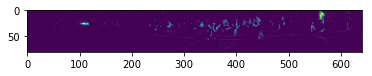

[[ 0.83704233]]


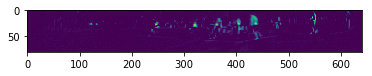

[[ 0.85184133]]


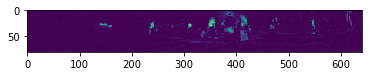

[[ 0.83823138]]


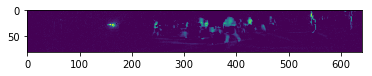

[[ 0.84611058]]


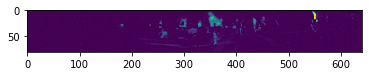

[[ 0.8562628]]


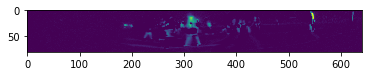

[[ 0.85806257]]


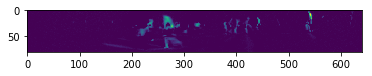

[[ 0.8670215]]


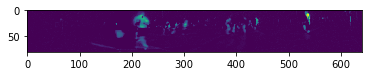

[[ 0.87400901]]


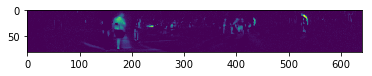

[[ 0.86421418]]


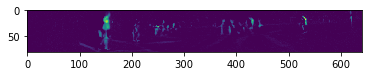

[[ 0.87472206]]


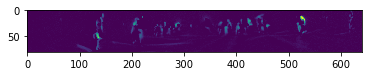

[[ 0.86599213]]


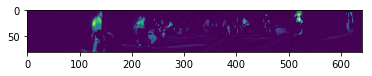

[[ 0.8619827]]


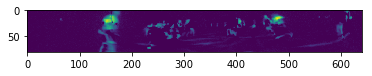

[[ 0.85271549]]


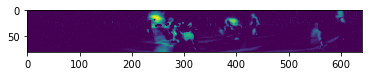

[[ 0.85847396]]


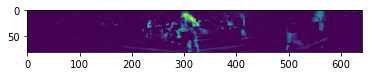

[[ 0.87211764]]


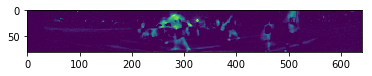

[[ 0.88612562]]


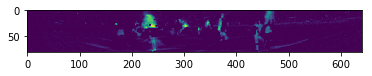

[[ 0.90915346]]


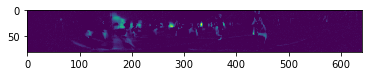

[[ 0.89753115]]


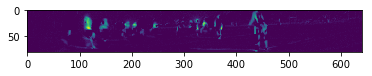

[[ 0.91549599]]


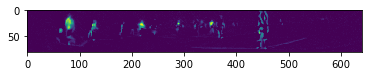

[[ 0.92765433]]


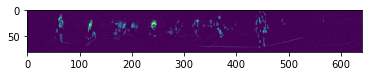

[[ 0.92853409]]


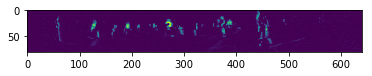

[[ 0.91191941]]


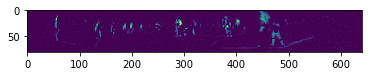

[[ 0.90806895]]


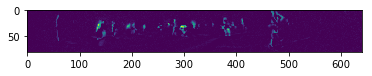

[[ 0.88532478]]


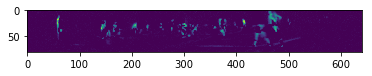

[[ 0.8676517]]


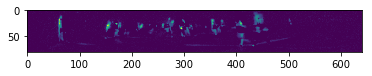

[[ 0.85385913]]


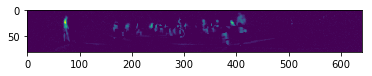

[[ 0.848405]]


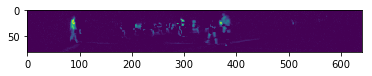

[[ 0.85010087]]


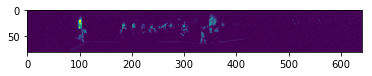

[[ 0.84620619]]


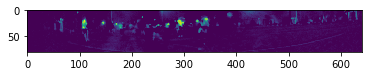

[[ 0.84241986]]


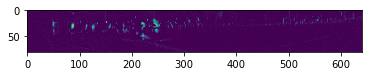

[[ 0.85024613]]


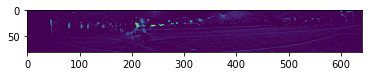

[[ 0.81763887]]


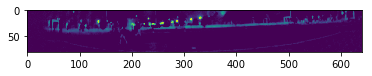

[[ 0.85393894]]


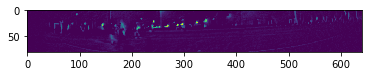

[[ 0.85130429]]


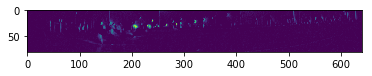

[[ 0.85126817]]


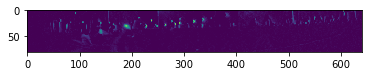

[[ 0.84739172]]


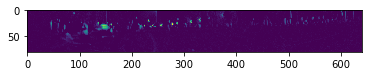

[[ 0.85243595]]


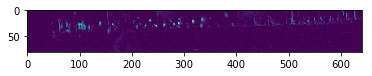

[[ 0.85666949]]


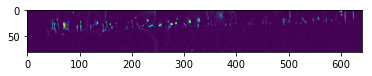

[[ 0.88870329]]


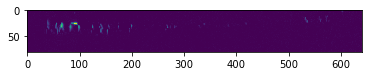

[[ 0.89136702]]


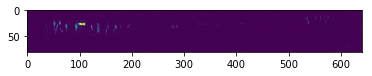

[[ 0.89205217]]


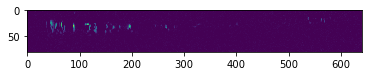

[[ 0.89044368]]


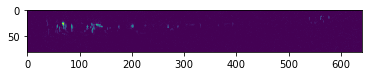

[[ 0.88845599]]


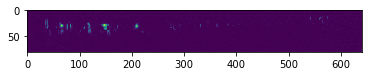

[[ 0.87695712]]


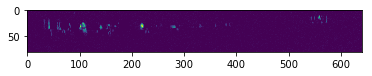

[[ 0.86870456]]


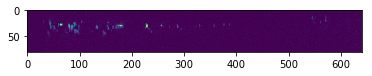

[[ 0.86755836]]


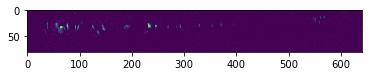

[[ 0.86274946]]


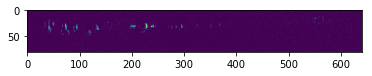

[[ 0.85369003]]


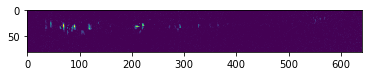

[[ 0.85388738]]


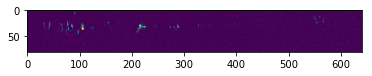

[[ 0.84539437]]


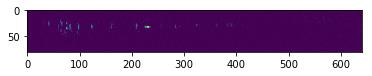

[[ 0.84315979]]


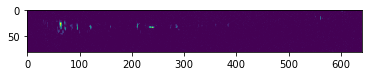

[[ 0.84834504]]


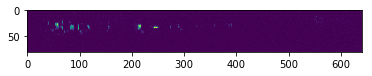

[[ 0.85469067]]


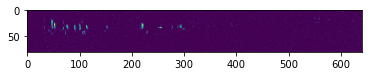

[[ 0.85718256]]


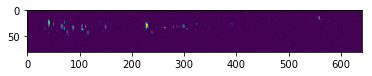

[[ 0.86022389]]


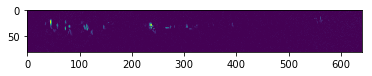

[[ 0.86122346]]


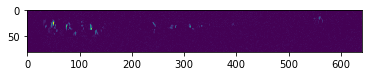

[[ 0.84910262]]


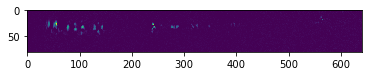

[[ 0.84201288]]


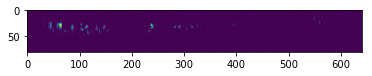

[[ 0.85134465]]


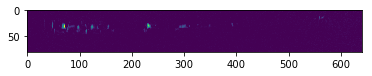

[[ 0.84971255]]


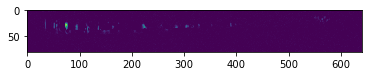

[[ 0.84634703]]


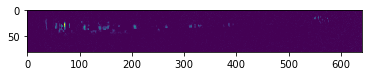

[[ 0.84234911]]


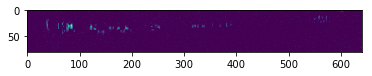

[[ 0.8459022]]


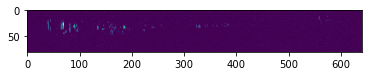

[[ 0.8387205]]


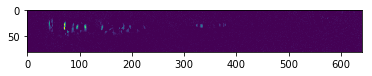

[[ 0.83463591]]


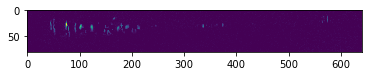

[[ 0.83762228]]


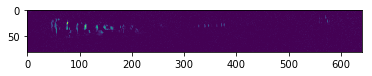

[[ 0.84069228]]


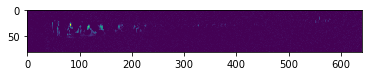

[[ 0.83280396]]


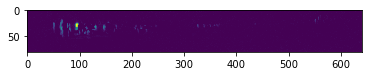

[[ 0.84593672]]


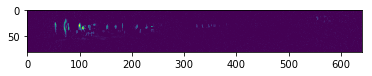

[[ 0.85974097]]


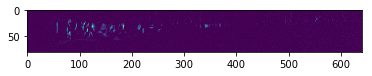

[[ 0.85786206]]


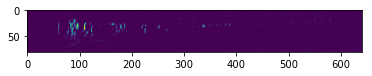

[[ 0.86190248]]


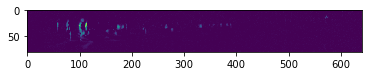

[[ 0.86377263]]


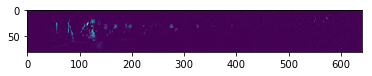

[[ 0.86276948]]


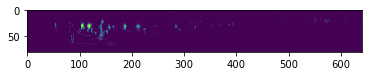

[[ 0.86595333]]


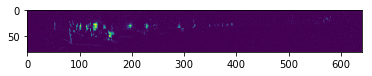

[[ 0.87661684]]


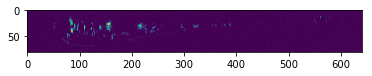

[[ 0.87697953]]


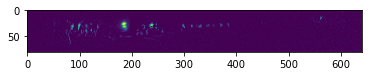

[[ 0.87142885]]


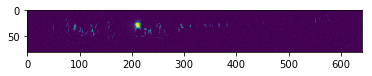

[[ 0.85447711]]


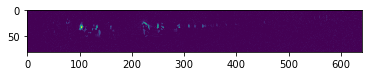

[[ 0.84872758]]


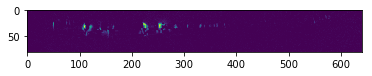

[[ 0.85157615]]


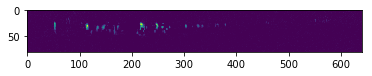

[[ 0.86559516]]


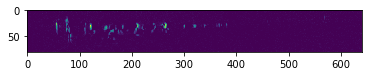

[[ 0.8731761]]


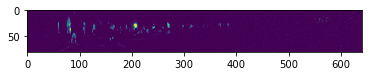

[[ 0.87400377]]


In [245]:
model.reset_states()
for i in range(100):
    plt.imshow(X[i].reshape(80,640))
    plt.show()
    print(model.predict(X[i:i+1].reshape(1,1,80,640,1)))

In [ ]:
plt.imshow(X[0].reshape(80,640))

In [232]:
model.reset_states()

In [178]:
preds = model.predict(X[:100].reshape(10,10,80,640,1))

In [179]:
preds

array([[ 0.59441829],
       [ 0.9555015 ],
       [ 0.92889589],
       [ 0.71221304],
       [ 0.86512291],
       [ 0.41709501],
       [ 0.31334955],
       [ 0.32152784],
       [ 0.38273358],
       [ 0.39260325]], dtype=float32)

In [99]:
x_test[1].shape

(80, 640, 1)

In [101]:
from scipy.ndimage.interpolation import shift


In [103]:
shift(x_test[1], [10,0,0]).shape

(80, 640, 1)

0.5765625 0
369 350


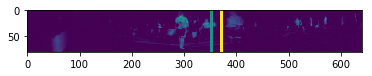

0.5765625 0
369 350


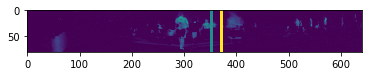

0.5765625 0
369 342


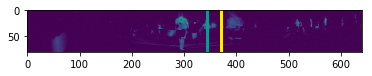

0.5765625 0
369 334


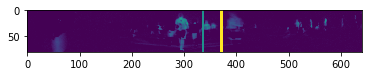

0.5765625 0
369 329


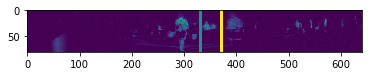

0.5765625 0
369 330


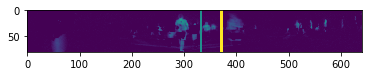

0.5765625 0
369 335


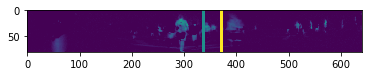

0.5765625 0
369 341


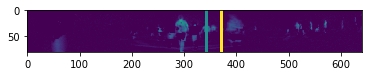

0.5765625 0
369 342


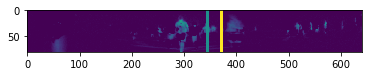

0.5765625 0
369 340


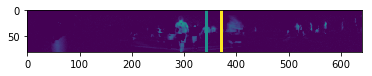

0.5765625 0
369 336


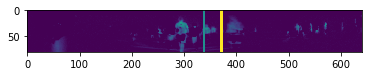

0.5765625 0
369 333


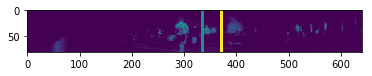

0.5765625 0
369 326


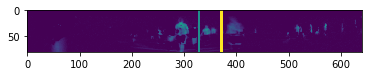

0.5765625 0
369 319


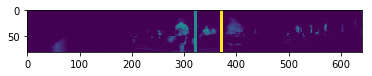

0.5765625 0
369 308


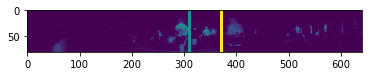

0.5765625 0
369 295


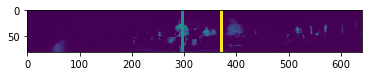

0.5765625 0
369 273


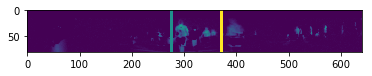

0.5765625 0
369 249


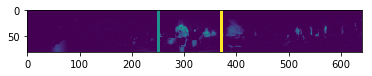

0.5765625 0
369 223


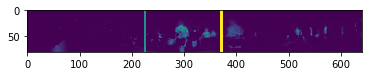

0.5765625 0
369 199


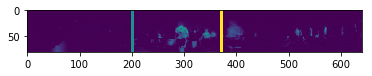

0.5765625 0
369 172


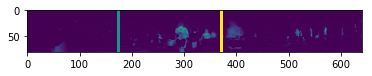

0.5765625 0
369 156


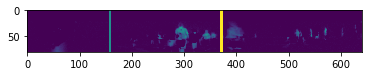

0.5765625 0
369 147


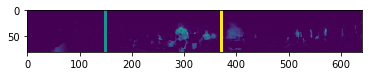

0.5765625 0
369 138


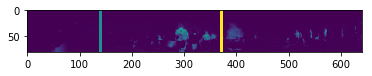

0.5765625 0
369 129


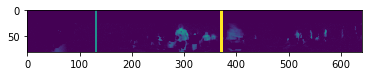

0.5765625 0
369 130


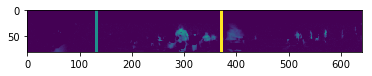

0.5765625 0
369 132


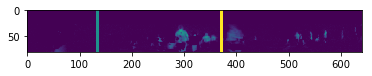

0.5765625 0
369 132


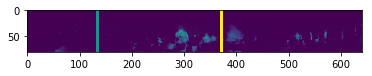

0.5765625 0
369 128


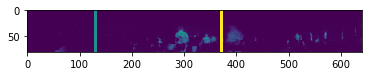

0.5765625 0
369 124


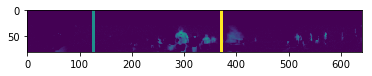

0.5765625 0
369 120


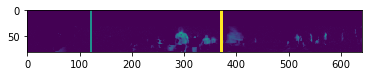

0.5765625 0
369 115


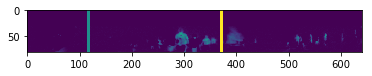

0.5765625 0
369 112


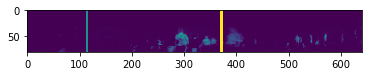

0.5765625 0
369 109


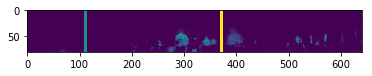

0.5765625 0
369 108


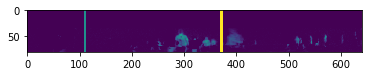

0.5765625 0
369 103


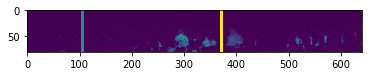

0.5765625 0
369 98


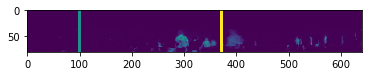

0.5765625 0
369 93


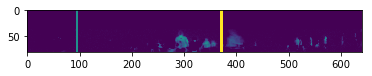

0.5765625 0
369 89


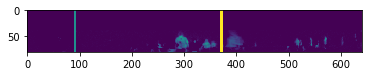

0.5765625 0
369 85


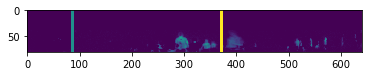

0.5765625 0
369 81


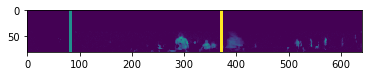

0.5765625 0
369 76


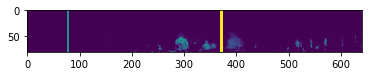

0.5765625 0
369 70


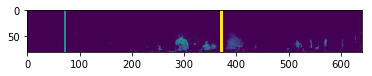

0.5765625 0
369 66


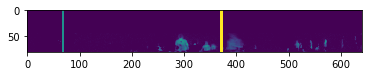

0.5765625 0
369 64


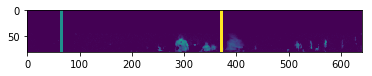

0.5765625 0
369 64


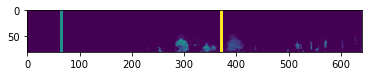

0.5765625 0
369 63


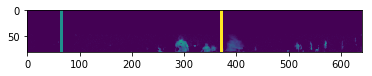

0.5765625 0
369 63


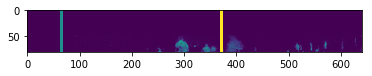

0.5765625 0
369 63


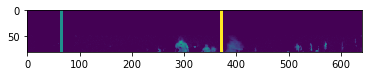

0.5765625 0
369 62


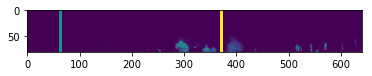

In [126]:
for i in range(0,50,1):
    x_shift = 0
    y_shift = i
    img_shift = shift(x_test[1], [y_shift,x_shift,0])
#     plt.imshow(img_shift.reshape(80,640))
    print_image_labels_comp([img_shift], [y_test.values[1]], model.predict(img_shift.reshape(1,80, 640, 1)))

0.29375 0
188 192


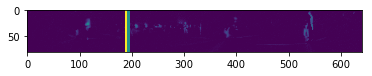

0.5765625 1
369 350


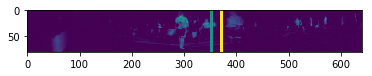

0.1890625 2
121 180


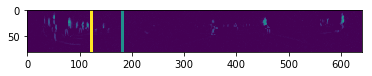

0.696875 3
446 415


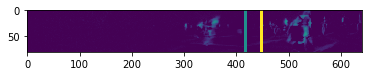

0.7703125 4
493 514


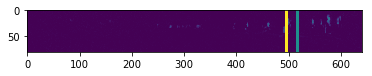

0.74375 5
476 499


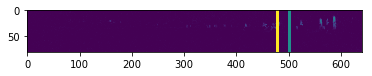

0.178125 6
114 83


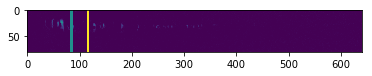

0.5203125 7
333 309


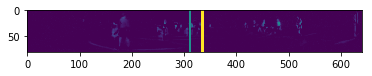

0.4234375 8
271 266


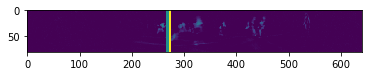

0.8109375 9
519 549


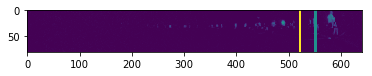

In [97]:
print_image_labels_comp(x_test[:10], y_test.values[:10], preds[:10])
# actual labels are yellow, predictions are blue

In [158]:
model.count_params()

12751617

In [45]:
import h5py

In [46]:
model.save('cnn_delta_80_640.h5')

In [47]:
np.save('test_delta_data',x_test)